In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('US-Covid.csv')
data.head()

,countyFIPS,County Name,State,StateFIPS,population,2020-06-01_cases,2020-06-02_cases,2020-06-03_cases,2020-06-04_cases,2020-06-05_cases,...,2020-12-25_deaths,2020-12-26_deaths,2020-12-27_deaths,2020-12-28_deaths,2020-12-29_deaths,2020-12-30_deaths,2020-12-31_deaths,2021-01-01_deaths,2021-01-02_deaths,2021-01-03_deaths
0,1001,Autauga County,AL,1,55869,233,238,239,241,248,...,46,46,47,47,47,48,48,50,50,50
1,1003,Baldwin County,AL,1,223234,292,292,292,293,296,...,151,151,152,152,156,160,161,169,169,169
2,1005,Barbour County,AL,1,24686,172,175,177,177,183,...,32,32,32,32,32,32,32,33,33,33
3,1007,Bibb County,AL,1,22394,76,76,76,76,76,...,42,42,42,42,42,46,46,46,46,46
4,1009,Blount County,AL,1,57826,63,63,63,63,64,...,58,58,58,58,58,63,63,63,63,63


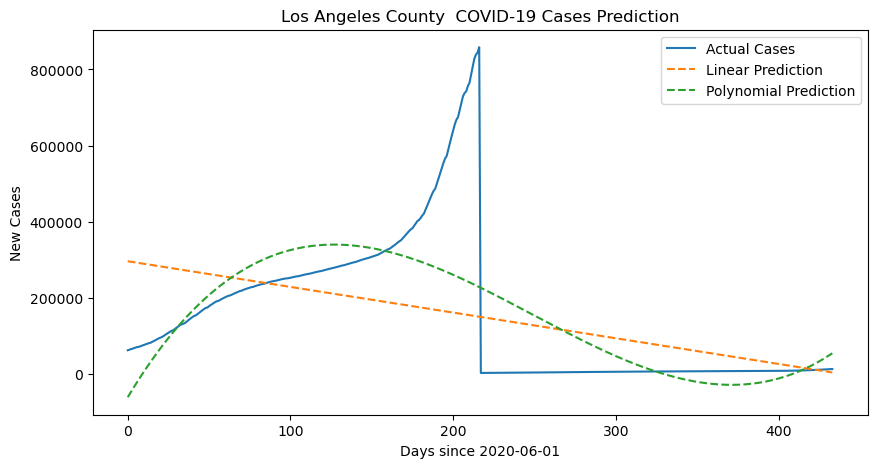

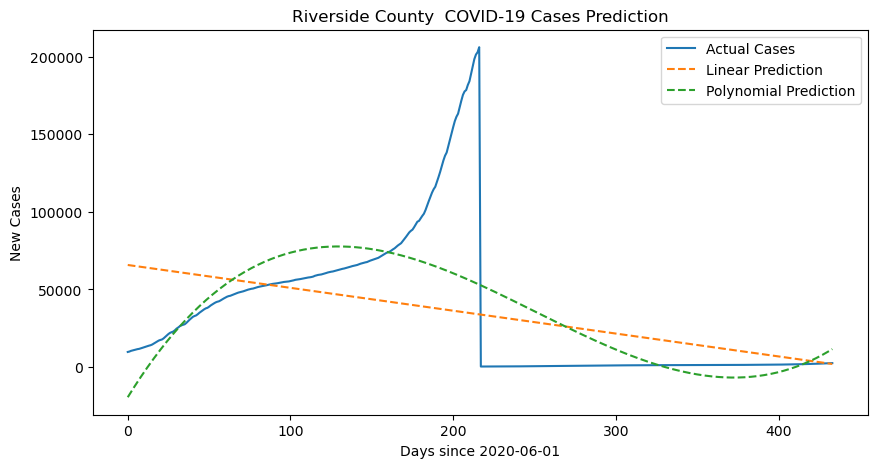

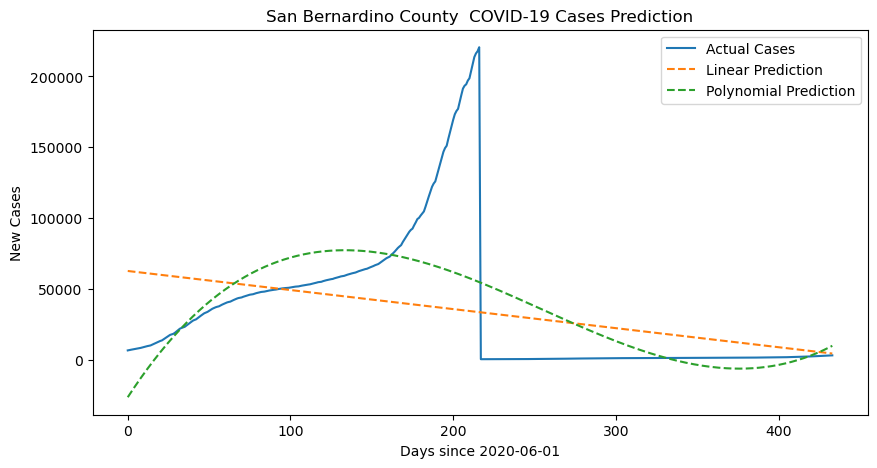

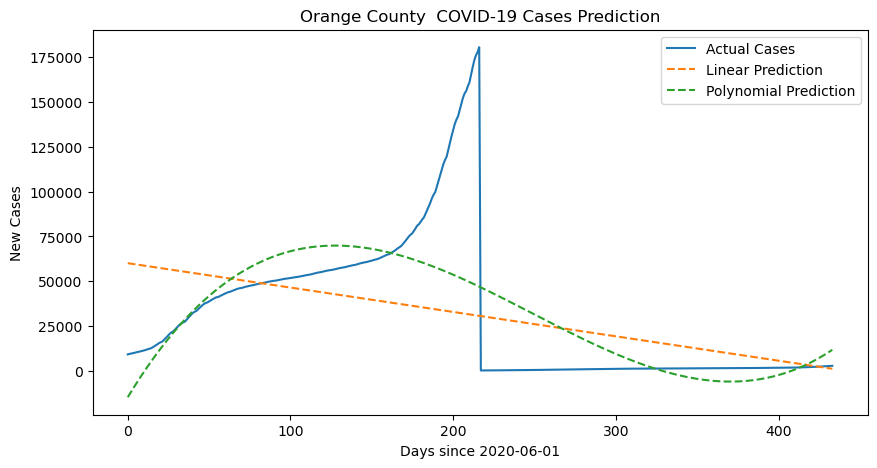

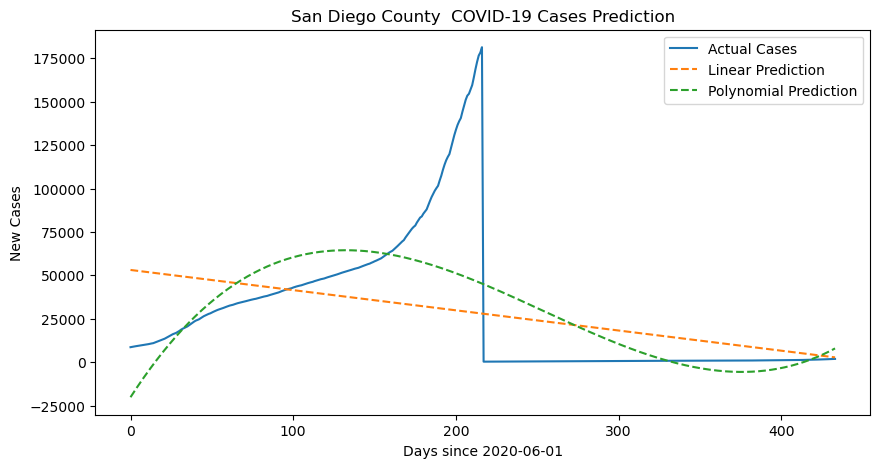

In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load data
enrichment_data = pd.read_csv(r"C:\Users\bluev\Downloads\5_states_and_CA.csv")
covid_data = pd.read_csv('US-Covid.csv')

# Filter for California and find the top 5 counties by total cases
covid_data_ca = covid_data[covid_data['State'] == 'CA']
# Use .loc to avoid SettingWithCopyWarning
covid_data_ca = covid_data_ca.copy()  # Create a copy of the DataFrame to work on
covid_data_ca['total_cases'] = covid_data_ca[[col for col in covid_data_ca.columns if '_cases' in col]].sum(axis=1)

top_counties = covid_data_ca.nlargest(5, 'total_cases')['County Name']

# Perform analysis for each top county
for county in top_counties:
    county_data = covid_data_ca[covid_data_ca['County Name'] == county]

    # Melt the DataFrame to long format
    county_data_long = county_data.melt(id_vars=['County Name', 'State', 'population'], 
                                         var_name='date_cases', 
                                         value_name='cases')
    
    # Extract date from the 'date_cases' column
    county_data_long['date'] = county_data_long['date_cases'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]
    county_data_long['date'] = pd.to_datetime(county_data_long['date'], errors='coerce')
    
    # Drop rows where date is NaT or cases are NaN
    county_data_long = county_data_long.dropna(subset=['date', 'cases'])
    
    # Set the date as index
    county_data_long = county_data_long.set_index('date')
    
    # Prepare regression model inputs
    county_cases = county_data_long['cases'].values
    days_since_start = np.arange(len(county_cases)).reshape(-1, 1)
    X = days_since_start
    y_cases = county_cases
    
    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X, y_cases)
    y_cases_pred_linear = linear_model.predict(X)
    
    # Polynomial Regression (Degree 3)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y_cases)
    y_cases_pred_poly = poly_model.predict(X_poly)
    
    # RMSE Calculation
    rmse_linear = np.sqrt(np.mean((y_cases - y_cases_pred_linear) ** 2))
    rmse_poly = np.sqrt(np.mean((y_cases - y_cases_pred_poly) ** 2))
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(X, y_cases, label="Actual Cases")
    plt.plot(X, y_cases_pred_linear, label="Linear Prediction", linestyle="--")
    plt.plot(X, y_cases_pred_poly, label="Polynomial Prediction", linestyle="--")
    plt.title(f"{county} COVID-19 Cases Prediction")
    plt.xlabel("Days since 2020-06-01")
    plt.ylabel("New Cases")
    plt.legend()
    plt.show()


In [37]:
enrichment_data.head()

,Label (Grouping),California!!Estimate,California!!Percent,Idaho!!Estimate,Idaho!!Percent,Montana!!Estimate,Montana!!Percent,Oregon!!Estimate,Oregon!!Percent,Washington!!Estimate,Washington!!Percent,Wyoming!!Estimate,Wyoming!!Percent
0,EMPLOYMENT STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Population 16 years and over,"31,403,964","31,403,964","1,360,062","1,360,062","859,185","859,185","3,408,422","3,408,422","6,038,812","6,038,812","461,417","461,417"
2,In labor force,"20,016,955",63.7%,"858,590",63.1%,"545,629",63.5%,"2,134,435",62.6%,"3,904,996",64.7%,"303,956",65.9%
3,Civilian labor force,"19,875,973",63.3%,"854,040",62.8%,"542,584",63.2%,"2,130,784",62.5%,"3,848,596",63.7%,"300,597",65.1%
4,Employed,"18,646,894",59.4%,"818,085",60.2%,"520,043",60.5%,"2,014,487",59.1%,"3,660,034",60.6%,"287,375",62.3%


In [39]:
import pandas as pd
import numpy as np
from scipy import stats

# Load enrichment data and COVID data for California
enrichment_data = pd.read_csv(r"C:\Users\bluev\Downloads\5_states_and_CA.csv")
covid_data = pd.read_csv(r"C:\Users\bluev\Downloads\Group7ClassProject\Stage II\Hamza Ahmed\filtered_super_dates_June2020_Jan2021_and_6_states.csv")

# Assume 'cases_per_100k' column exists, or calculate it if needed:
# Here, "cases_per_100k" should be calculated per county as the total cases divided by the population in that county, scaled to per 100,000 people.

# Calculate cases per 100,000 population for each county in California
covid_data_ca = covid_data[covid_data['State'] == 'CA']
covid_data_ca['cases_per_100k'] = (covid_data_ca[[col for col in covid_data_ca.columns if '_cases' in col]].sum(axis=1) / covid_data_ca['population']) * 100000

# Merge COVID data with enrichment data on relevant fields (adjust if necessary)
# Ensure both datasets have matching columns for merging (e.g., by county or other appropriate key)
merged_data = covid_data_ca.merge(enrichment_data, left_on='County Name', right_on='Label (Grouping)', how='left')

# Define T-test function
def perform_t_test(data, enrichment_column, outcome_column='cases_per_100k'):
    # Divide into high and low groups based on median of enrichment variable
    median_value = data[enrichment_column].median()
    high_group = data[data[enrichment_column] > median_value][outcome_column]
    low_group = data[data[enrichment_column] <= median_value][outcome_column]
    
    # Perform T-test
    t_stat, p_value = stats.ttest_ind(high_group, low_group)
    print(f"T-test for {enrichment_column}: t-statistic = {t_stat}, p-value = {p_value}")

# Perform T-tests for selected variables
perform_t_test(merged_data, 'Civilian labor force')
perform_t_test(merged_data, 'Employed')
perform_t_test(merged_data, 'With Health Insurance Coverage')


C:\Users\bluev\AppData\Local\Temp\ipykernel_30568\669377400.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_ca['cases_per_100k'] = (covid_data_ca[[col for col in covid_data_ca.columns if '_cases' in col]].sum(axis=1) / covid_data_ca['population']) * 100000


KeyError: 'County Name'

In [45]:
import pandas as pd
from scipy import stats

# Load your data
enrichment_data_ca = pd.read_csv(r"C:\Users\bluev\Downloads\5_states_and_CA.csv")
covid_data = pd.read_csv('US-Covid.csv')

# Clean up the enrichment data
enrichment_data_ca.columns = enrichment_data_ca.columns.str.strip()
enrichment_data_ca.set_index('Label (Grouping)', inplace=True)

# Select relevant enrichment variables
enrichment_variables = [
    'Employed', 
    'Civilian labor force', 
    'With health insurance coverage'  # Update if these labels need adjusting based on your data
]

# Check for missing variables
missing_variables = [var for var in enrichment_variables if var not in enrichment_data_ca.index]
if missing_variables:
    print(f"Warning: The following variables are missing: {missing_variables}")

# Extract available data
enrichment_data_selected = enrichment_data_ca.loc[enrichment_variables].T  # Transpose for easier merging

# Merge COVID data with enrichment data on relevant fields
merged_data = covid_data_ca.merge(enrichment_data_selected, left_on='County Name', right_index=True, how='left')

# Define the function to perform T-tests
def perform_t_test(data, variable):
    # Assuming 'COVID Cases' is the column to compare
    group1 = data[data['COVID Cases'] < 100][variable].dropna()  # Change this condition as needed
    group2 = data[data['COVID Cases'] >= 100][variable].dropna()

    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2, nan_policy='omit')
        print(f"T-test for {variable}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    else:
        print(f"Not enough data to perform T-test for {variable}")

# Perform T-tests for selected variables
for variable in enrichment_variables:
    perform_t_test(merged_data, variable)


KeyError: "None of [Index(['Employed', 'Civilian labor force', 'With health insurance coverage'], dtype='object', name='Label (Grouping)')] are in the [index]"

In [49]:
import pandas as pd
from scipy import stats

# Load your data
enrichment_data_ca = pd.read_csv(r"C:\Users\bluev\Downloads\5_states_and_CA.csv")
covid_data = pd.read_csv('US-Covid.csv')

# Clean up the enrichment data
enrichment_data_ca.columns = enrichment_data_ca.columns.str.strip()  # Clean column names
enrichment_data_ca.set_index('Label (Grouping)', inplace=True)

# Check the index to understand its structure
print("Index of enrichment_data_ca:", enrichment_data_ca.index.tolist())

# Clean the index by stripping whitespace
enrichment_data_ca.index = enrichment_data_ca.index.str.strip()

# Select relevant enrichment variables
enrichment_variables = [
    'Employed', 
    'Civilian labor force', 
    'With health insurance coverage'  # Adjust based on your actual labels
]

# Check for missing variables
missing_variables = [var for var in enrichment_variables if var not in enrichment_data_ca.index]
if missing_variables:
    print(f"Warning: The following variables are missing: {missing_variables}")

# Extract available data
try:
    enrichment_data_selected = enrichment_data_ca.loc[enrichment_variables].T  # Transpose for easier merging
except KeyError as e:
    print(f"KeyError: {e}. Please check the variable names.")

# Merge COVID data with enrichment data on relevant fields
merged_data = covid_data.merge(enrichment_data_selected, left_on='County Name', right_index=True, how='left')

# Define the function to perform T-tests
def perform_t_test(data, variable):
    group1 = data[data['COVID Cases'] < 100][variable].dropna()
    group2 = data[data['COVID Cases'] >= 100][variable].dropna()

    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2, nan_policy='omit')
        print(f"T-test for {variable}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    else:
        print(f"Not enough data to perform T-test for {variable}")

# Perform T-tests for selected variables
for variable in enrichment_variables:
    perform_t_test(merged_data, variable)


Index of enrichment_data_ca: ['EMPLOYMENT STATUS', '\xa0\xa0\xa0\xa0Population 16 years and over', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0In labor force', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Civilian labor force', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Employed', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployed', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Armed Forces', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Not in labor force', '\xa0\xa0\xa0\xa0Civilian labor force', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Unemployment Rate', '\xa0\xa0\xa0\xa0Females 16 years and over', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0In labor force', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Civilian labor force', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0Employed', '\xa0\xa0\xa0\xa0Own children of the householder under 6 years', '\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0All parents in family in labor force', '\xa0\xa0\xa0\xa0Own children of t

KeyError: 'COVID Cases'